# Ames, Iowa Housing - Regression
The dataset used for this notebook was the Ames Housing Dataset provided by Kaggle, https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data.

From an internal competition between my peer data science fellows at General Assembly, the best performing model in this notebook placed top 10% on the test set.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures, OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline
warnings.filterwarnings('ignore')

# Import Data and EDA

In [2]:
# Import CSVs
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# See shape of training and test sets
print('Training set: ', train_df.shape)
print('Test set: ', test_df.shape)

Training set:  (2051, 82)
Test set:  (879, 80)


In [3]:
# See training set's head
train_df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,1,2010,WD,Abnorml,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,138500


This is a relatively small dataset with a little over 2000 datapoints in the training set, however there's also a lot of features to work with. We'll have to be wary as this type of situation can cause predictions with high variance and create an overfit model. <br/><br/>
Also note the test set has 2 less columns than the training set. I suspect these would be the targets, but let's confirm.

In [4]:
[col for col in train_df.columns if col not in test_df.columns]

['Sale Condition', 'SalePrice']

As suspected these columns look to be targets; 1 for classification and 1 for regression. We'll use this knowledge to create our feature matrix and target vector later after some preprocessing. As our focus for this project is regression, we'll set our target to **SalePrice** and drop the Sale Condition column. <br/><br/>
For now we'll rename our columns to exclude spaces and put underscores in place of them for filtering cleanliness. 

In [5]:
# Place '_' inplace of spaces in column names
train_df.columns = [col.replace(' ', '_') for col in train_df.columns]
test_df.columns = [col.replace(' ', '_') for col in test_df.columns]

We'll start our EDA by seeing how clean our data is. We'll first check for Nans.

In [6]:
train_df.isnull().sum()[train_df.isnull().sum() != 0]

Lot_Frontage       330
Alley             1911
Mas_Vnr_Type        22
Mas_Vnr_Area        22
Bsmt_Qual           55
Bsmt_Cond           55
Bsmt_Exposure       58
BsmtFin_Type_1      55
BsmtFin_SF_1         1
BsmtFin_Type_2      56
BsmtFin_SF_2         1
Bsmt_Unf_SF          1
Total_Bsmt_SF        1
Bsmt_Full_Bath       2
Bsmt_Half_Bath       2
Fireplace_Qu      1000
Garage_Type        113
Garage_Yr_Blt      114
Garage_Finish      114
Garage_Cars          1
Garage_Area          1
Garage_Qual        114
Garage_Cond        114
Pool_QC           2042
Fence             1651
Misc_Feature      1986
dtype: int64

So.. quite a bit of null values in this dataset. One option to deal with these Nans is to drop all columns where a Nan is present. However because we have so few datapoints in the training set and I wouldn't want to delete valuable features, I'll refer back to the data dictionary and figure which columns I can impute. 

Given the data dictionary and number of Nans, I'll deal with these columns in the following manner.

|Feature |Number of Nans |Action |
|---|---|---|
|Lot Frontage   |330   |Drop column  |
|Alley   |1911   |Impute 'None'   |
|Mas Vnr Type   |22   |Impute 'None'   |
|Mas Vnr Area|22|Impute 0|
|Bsmt Qual|55|Impute 'None'|
|Bsmt Cond|55|Impute 'None'|
|Bsmt Exposure|58|Impute 'None'|
|BsmtFin Type 1|55|Impute 'None'|
|BsmtFin SF 1     |    1 |Delete row|
|BsmtFin Type 2   |   56 |Impute 'None'|
|BsmtFin SF 2     |    1 |Delete row|
|Bsmt Unf SF      |    1 |Delete row|
|Total Bsmt SF     |   1 |Delete row|
|Bsmt Full Bath    |   2 |Delete row|
|Bsmt Half Bath    |   2 |Delete row|
|Fireplace Qu    |  1000 |Impute 'None'|
|Garage Type     |   113 |Impute 'None'|
|Garage Yr Blt    |  114 |Drop column|
|Garage Finish   |   114 |Impute 'None'|
|Garage Cars     |     1 |Delete row|
|Garage Area     |     1 |Delete row|
|Garage Qual     |   114 |Impute 'None'|
|Garage Cond     |   114 |Impute 'None'|
|Pool QC        |   2042 |Impute 'None'|
|Fence          |   1651 |Impute 'None'|
|Misc Feature   |   1986 |Impute 'None'|


In [7]:
# Group features by common action
drop_columns = ['Lot_Frontage', 'Garage_Yr_Blt']
delete_rows = ['BsmtFin_SF_1', 'BsmtFin_SF_2', 'Bsmt_Unf_SF', 'Total_Bsmt_SF', 'Bsmt_Full_Bath', 'Bsmt_Half_Bath', \
              'Garage_Cars', 'Garage_Area']
impute_0 = ['Mas_Vnr_Area'] 
impute_none = ['Alley', 'Mas_Vnr_Type', 'Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_Type_2', \
              'Fireplace_Qu', 'Garage_Type', 'Garage_Finish', 'Garage_Qual', 'Garage_Cond', 'Pool_QC', 'Fence', \
               'Misc_Feature']

# Create data cleaning function for ease of repeatability
def clean_features(df):
    
    # Drop columns
    [df.drop(col, axis=1, inplace=True) for col in drop_columns]
    
    # Delete rows
    df[delete_rows].dropna(axis=0, inplace=True)
    
    # Impute 0
    df[impute_0].fillna(0, inplace=True)
    
    # Impute 'None'
    [df.fillna('None', inplace=True) for col in impute_none]
    
# Run function of train and test sets
clean_features(train_df)
clean_features(test_df)

We can now split our training set to make our feature matrix and target vector. As mentioned before as this is a regression problem, we'll make Sale Price our target vector and will discard Sale Condition.

In [8]:
y_train = train_df['SalePrice']
X_train = train_df.drop(['Sale_Condition', 'SalePrice'], axis=1)

# Rename test set for consistency
X_test = test_df

For our model to deal with the categorical features, we'll need to one hot encode them.

In [9]:
# Identify categorical columns
cat_feature_dtypes = X_train.dtypes[(X_train.dtypes != 'int64') & (X_train.dtypes != 'float64')].to_frame().reset_index()

cat_features = np.array(cat_feature_dtypes['index'])

# Spot check for any numerical columns that might've leaked in
# for col in cat_features:
#     print(col, X_train[col].unique())

Through the above query we can identify a few numerical columns that leaked to the categorical feature list due to having 'None's. We'll deal with these by imputing '0's in place of 'None's.

In [10]:
num_features = ['Mas_Vnr_Area', 'BsmtFin_SF_1', 'BsmtFin_SF_2', 'Bsmt_Unf_SF', 'Total_Bsmt_SF', 'Bsmt_Full_Bath', \
               'Bsmt_Half_Bath', 'Garage_Cars', 'Garage_Area']

X_train[num_features] = X_train[num_features].apply(lambda x: x.replace('None', 0))
X_test[num_features] = X_test[num_features].apply(lambda x: x.replace('None', 0))

# Remove numerical features from categorical features list
cat_features = [col for col in cat_features if col not in num_features]

# One Hot Encode categorical features
X_train = pd.get_dummies(X_train, columns=cat_features)
X_test = pd.get_dummies(X_test, columns=cat_features)

X_train.shape, X_test.shape

((2051, 303), (879, 287))

Binarizing our categorical features made our training and test feature matrices have different number of columns. The obvious deduction here is some of the categorical entries were not present in both sets. For this problem we'll deal with the issue by creating dummy columns in the test feature matrix. Any dummy columns in the test feature matrix that doesn't exist in the training feature matrix, we'll delete.

In [11]:
dummy_col_list = [col for col in X_train.columns if col not in X_test.columns]

for col in dummy_col_list:
    X_test[col] = 0

[X_test.drop(col, axis=1, inplace=True) for col in X_test.columns if col not in X_train.columns]

X_train.shape, X_test.shape

((2051, 303), (879, 303))

Our feature matrices have unique identifier columns that we should remove before we feed the data into our model. We'll store the IDs as we'll need them for our Kaggle submissions.

In [12]:
train_Id = X_train['Id']
test_Id = X_test['Id']

X_train.drop(['Id', 'PID'], axis=1, inplace=True)
X_test.drop(['Id', 'PID'], axis=1, inplace=True)

As the last preprocessing step, we'll use Standard Scaler to normalize our features.

In [13]:
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

With our data finally preprocessed, let's do some explaratory data analysis.

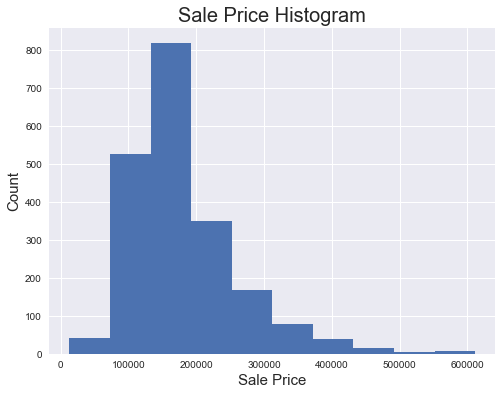

In [14]:
# Build histogram of sales price
plt.figure(figsize=(8, 6))
plt.hist(y_train)
plt.title('Sale Price Histogram', fontsize=20)
plt.xlabel('Sale Price', fontsize=15)
plt.ylabel('Count', fontsize=15)

Most houses look to be priced in the $100,000 - $300,000 range with the count tapering off as the price increases.

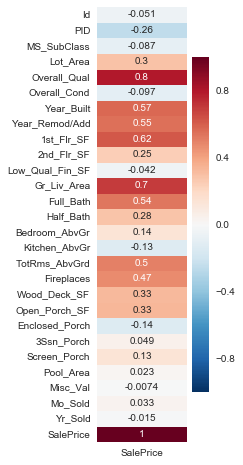

In [15]:
# View correlation for SalePrice
plt.figure(figsize=(2, 8))
sns.heatmap(train_df.corr()[['SalePrice']], annot=True)

The correlation matrix above shows a high level of features that are highly correlated with Sale Price. Some of the features with high correlations are intuitive such as overall quality, year built, and square footage of areas- some are not so intuitive such as having a fireplace. We need to be careful how we interpret this however as having a fireplace I would assume is correlated with features such as higher square footage.

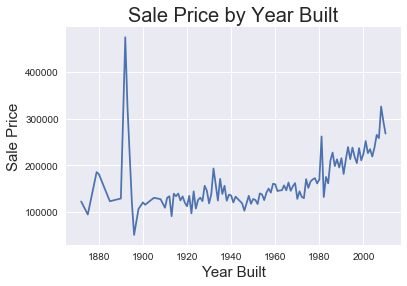

In [16]:
plt.plot(train_df.groupby('Year_Built').mean()[['SalePrice']])
plt.title('Sale Price by Year Built', fontsize=20)
plt.xlabel('Year Built', fontsize=15)
plt.ylabel('Sale Price', fontsize=15)

# Modeling

### LassoCV
With a dataset with a large number of features, I typically like to run a lasso regression to begin the modeling process. The reason being is I can test if there's a strong linear relationship in addition to helping with feature selection.

In [17]:
lasso = Lasso()

lasso_cvs = cross_val_score(lasso, Xs_train, y_train, cv=10)

print('Crossfold mean: ', lasso_cvs.mean())
print('Crossfold std: ', lasso_cvs.std())

Crossfold mean:  0.842522141858
Crossfold std:  0.143216615031


As a first model without any parameter/hyperparameter tuning, the accuracy of the model isn't too bad. Let's see how many features our Lasso model zero-ed out.

In [18]:
lasso.fit(Xs_train, y_train)

print('Number of total features: ', Xs_train.shape[1])
print('Number of zero-ed out features: ', len(lasso.coef_) - np.count_nonzero(lasso.coef_))

Number of total features:  301
Number of zero-ed out features:  27


~9% of the features were zero-ed out- was hoping for more. This is indicative that many of the features are relevant for predicitng the target.

Let's see which features had the highest coefficients.

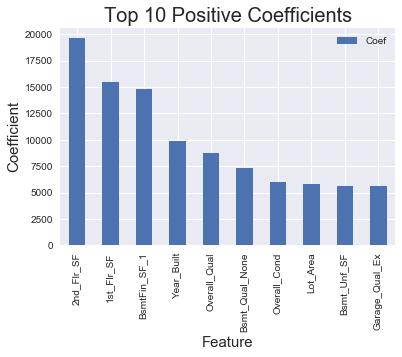

Top 10 positive coefficients:
            Feature          Coef
12       2nd_Flr_SF  19613.768572
11       1st_Flr_SF  15464.123564
7      BsmtFin_SF_1  14839.011783
4        Year_Built   9850.097033
2      Overall_Qual   8713.977296
187  Bsmt_Qual_None   7296.196516
3      Overall_Cond   6052.415005
1          Lot_Area   5772.053783
9       Bsmt_Unf_SF   5672.676870
261  Garage_Qual_Ex   5592.175737
------------------------------------------------------------


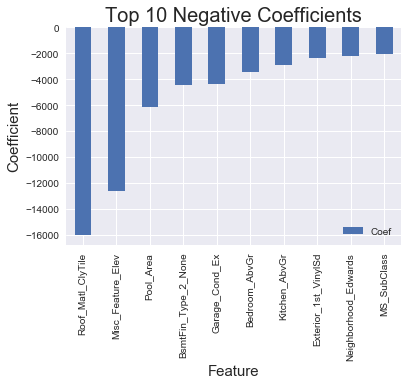


Top 10 negative coefficients:
                  Feature          Coef
129     Roof_Matl_ClyTile -15964.458372
286     Misc_Feature_Elev -12626.418010
30              Pool_Area  -6113.551289
212   BsmtFin_Type_2_None  -4397.302412
267        Garage_Cond_Ex  -4329.424931
19          Bedroom_AbvGr  -3413.139016
20          Kitchen_AbvGr  -2880.559786
147  Exterior_1st_VinylSd  -2352.017827
72   Neighborhood_Edwards  -2174.616441
0             MS_SubClass  -2057.790297


In [19]:
lasso_df = pd.DataFrame(X_train.columns, columns=['Feature'])
lasso_df['Coef'] = lasso.coef_

pos = lasso_df.sort_values(['Coef'], ascending=False).head(10)
neg = lasso_df.sort_values(['Coef']).head(10)

pos.plot(kind='bar', x='Feature', y='Coef')
plt.ylabel('Coefficient', fontsize=15)
plt.xlabel('Feature', fontsize=15)
plt.title('Top 10 Positive Coefficients', fontsize=20)
plt.show()
print('Top 10 positive coefficients:')
print(pos)

print('-'*60)

neg.plot(kind='bar', x='Feature', y='Coef')
plt.ylabel('Coefficient', fontsize=15)
plt.xlabel('Feature', fontsize=15)
plt.title('Top 10 Negative Coefficients', fontsize=20)
plt.show()
print('')
print('Top 10 negative coefficients:')
print(neg)

The top 10 lists are pretty intuitive to understand. The sales price of the house goes up with the higher square footage of various areas. The features included in the top 10 negative coefficients list can be indicative of features home buyers don't value or even dislike- the number one being a roof made of clay tiles. 

### Boosted Trees
Our linear regression with l1 regularization performed fairly well, but I have a feeling an ensembled tree could yield a model with better predictive power. 

Random forest is my favorite model to run because on top of its historically high predictive power, the algorithm makes a lot of sense. Decision trees are very good at creating predictive models, but are prone to overfit. By coupling it with an ensembling method, it helps mitigate the overfitting issue. In addition, as each tree in random forest selects different features, it does a good job at decorrelating features in your dataset.

In [20]:
rf = RandomForestRegressor()

cross_val_score(rf, Xs_train, y_train, cv=10).mean()

0.87269258888746626

Better, but not by much. Let's do some hyperparameter tuning through gridsearch to see if we can get a boost in accuracy.

In [21]:
params_grid = {
    'n_estimators': [5, 10, 15, 20, 25],
    'max_depth': [1, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 3, 4, 5]
}

grid_search = GridSearchCV(rf, params_grid, cv=10)

grid_search.fit(Xs_train, y_train)
print(grid_search.best_score_, grid_search.best_params_)

0.86550656617 {'max_depth': 6, 'min_samples_split': 5, 'n_estimators': 20}


Surprisingly our base model performed almost equally as well as our our hyperparameter tuned model if not slightly better.

While we're running boosted trees, we should run Gradient Boost which is notorious for being a Kaggle competition favorite because of its historically high predictive power. 

In [22]:
gbr = GradientBoostingRegressor()

cross_val_score(gbr, Xs_train, y_train, cv=10).mean()

0.91633132776745874

We finally have a model with a cross validated score of above 90%!. As this looks to be a worthy contender for kaggle, we'll predict on the test set and see how it places in the competition.

In [23]:
gbr.fit(Xs_train, y_train)

gbr_pred = pd.DataFrame(gbr.predict(X_test), columns=['SalePrice'])
gbr_pred['Id'] = test_Id

# Change column order
gbr_pred = gbr_pred[['Id', 'SalePrice']]

gbr_pred.to_csv('gboost_submission.csv', index=False)

## Conclusions

The best performing model against the test set on kaggle was the gradient boosting regressor without any hyperparameter tuning. 

One big note is that the training set did not contain several columns existing the the training set. These few features make a significant impact to the score against the training data (~.08). Next steps would be to try to continue feature engineering by using clustering methods to try and add these missing columns in the test data.